This notebook is optimized for Google Colab.
I prefer if you upload it to colab and run it.

However, to run this locally, be sure you:
-  have python running locally, update the library install format from `!` to `%` so for example `!pip install foo` becomes `%pip install foo`
- store secrets as env variables in your local system using `os.environ.get("SECRET_NAME")` vs what I've currently implemtented



## Libraries

In [1]:
#@title Ragas/DeepEval install

!pip install ragas deepeval datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.1/86.1 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 246.8/246.8 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.1/542.1 kB 29.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 29.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 974.0/974.0 kB 39.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 314.7/314.7 kB 30.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 26.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 325.5/325.5 kB 32.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.1/71.1 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 29.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.6/289.6 kB 23.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.1/46.1 kB 2.2 MB/s eta 0:00:00
  Preparing metadata (

In [2]:
#fixes issues related to how colab handles async
!pip install nest_asyncio

In [3]:
#For DeepEval Bias testcase loop
import nest_asyncio
nest_asyncio.apply()

In [4]:
#@title Imports
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast

from IPython.display import display
from datasets import Dataset
from ast import literal_eval

from ragas.metrics import context_recall, context_precision, answer_relevancy, faithfulness
from ragas import evaluate

from deepeval import evaluate as deepeval_evaluate
from deepeval.metrics import BiasMetric
from deepeval.test_case import LLMTestCase

from google.colab import userdata

In [5]:
#@title Env Setup

openai_api_key = userdata.get('OPENAI_KEY')
os.environ['OPENAI_API_KEY'] = openai_api_key

In [6]:
#@title Data Loading and Preprocessing

url = "https://raw.githubusercontent.com/ByteanAtomResearch/ai-product-course-fer/main/synthetic_mangobot_data_extended.csv"
data = pd.read_csv(url)

# Preprocessing
def safe_eval(value):
    try:
        return ast.literal_eval(value)
    except (SyntaxError, ValueError):
        return []

data_samples = {
    'question': data['user_query'].tolist(),
    'answer': data['chatbot_response'].tolist(),
    'contexts': [safe_eval(ctx) for ctx in data['retrieved_contexts']],
    'ground_truth': data['relevant_contexts'].apply(lambda x: safe_eval(x)[0] if isinstance(safe_eval(x), list) and len(safe_eval(x)) > 0 else safe_eval(x)).tolist()
}

dataset = Dataset.from_dict(data_samples)
display(dataset.to_pandas().head())

,question,answer,contexts,ground_truth
0,Where do mangoes originally come from?,Mangoes are native to South Asia and have been...,[Mangoes originated in South Asia and have bee...,Mangoes originated in South Asia and have been...
1,Can you recommend a sweet but less common type...,The Kesar mango is known for its unique sweetn...,[Kesar mango is known for its unique sweetness...,Kesar mango is known for its unique sweetness ...
2,Are there any savory recipes using mangoes?,"Yes, mango salsa is a popular savory dish that...",[Mango salsa is a popular savory dish that com...,Mango salsa is a popular savory dish that comb...
3,What is the peak season for mangoes?,The peak season for mangoes is typically from ...,[The peak season for mangoes is typically from...,The peak season for mangoes is typically from ...
4,Do mangoes have any cultural significance?,Mangoes hold cultural significance in various ...,[Mangoes hold cultural significance in various...,Mangoes hold cultural significance in various ...


# RAGAS Metrics Calculation

In [7]:
#@title Metrics calcs for retrieved context recall and precision

def calculate_ragas_metrics(dataset):
    try:
        recall_score = evaluate(dataset, metrics=[context_recall])
        precision_score = evaluate(dataset, metrics=[context_precision])
        faithfulness_score = evaluate(dataset, metrics=[faithfulness])
        relevance_score = evaluate(dataset, metrics=[answer_relevancy])

        recall_df = recall_score.to_pandas()
        precision_df = precision_score.to_pandas()
        faithfulness_df = faithfulness_score.to_pandas()
        relevance_df = relevance_score.to_pandas()

        return recall_df, precision_df, faithfulness_df, relevance_df
    except Exception as e:
        print(f"Error calculating RAGAS metrics: {e}")
        return None, None, None, None

# Calculate metrics
recall_df, precision_df, faithfulness_df, relevance_df = calculate_ragas_metrics(dataset)

Evaluating:   0%|          | 0/51 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/51 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/51 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/51 [00:00<?, ?it/s]

# Visualize calculated outputs

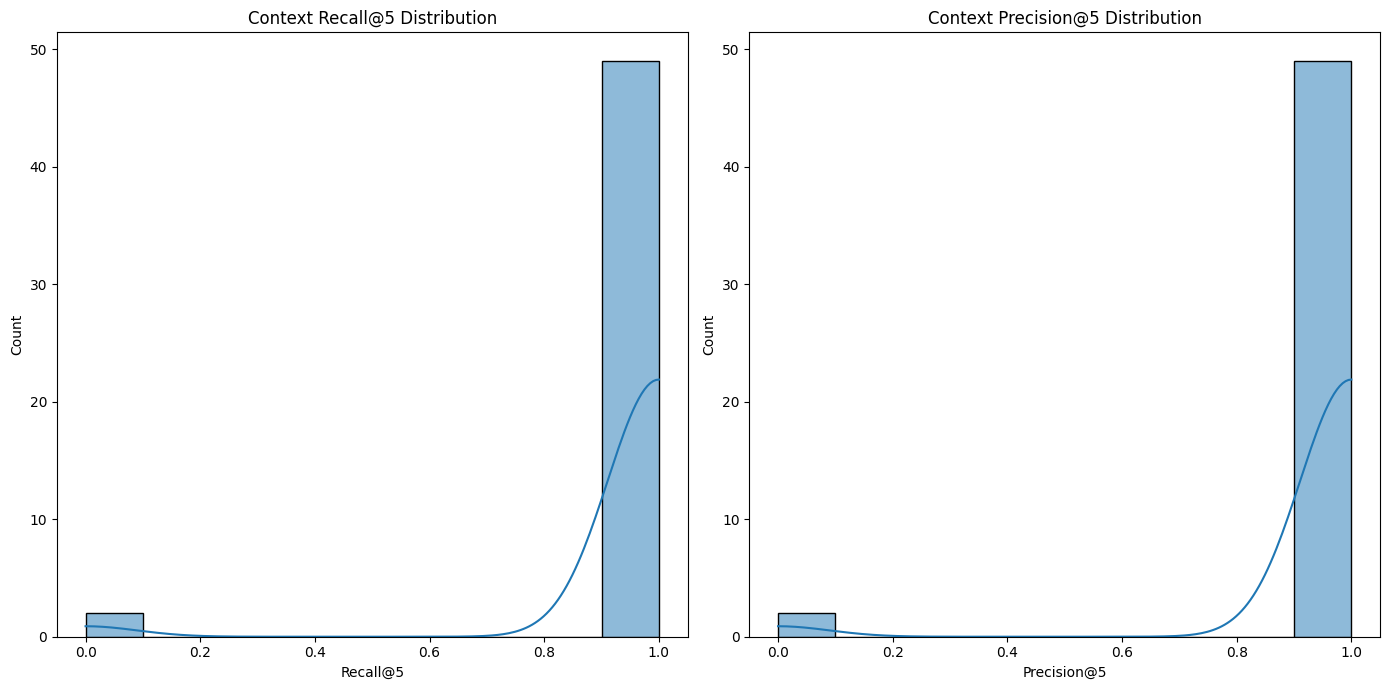

In [10]:
def plot_ragas_metrics(recall_df, precision_df):
    plt.figure(figsize=(14, 7))

    # Plot context recall
    plt.subplot(1, 2, 1)
    sns.histplot(recall_df['context_recall'], bins=10, kde=True)
    plt.title('Context Recall@5 Distribution')
    plt.xlabel('Recall@5')

    # Plot context precision
    plt.subplot(1, 2, 2)
    sns.histplot(precision_df['context_precision'], bins=10, kde=True)
    plt.title('Context Precision@5 Distribution')
    plt.xlabel('Precision@5')

    plt.tight_layout()
    plt.show()

# Call the function to plot RAGAS metrics
plot_ragas_metrics(recall_df, precision_df)

In [9]:
#@title Summarized RAGAS Results

def summarize_ragas_results(recall_df, precision_df, faithfulness_df, relevance_df):
    avg_recall = recall_df['context_recall'].mean()
    avg_precision = precision_df['context_precision'].mean()
    avg_faithfulness = faithfulness_df['faithfulness'].mean()
    avg_relevance = relevance_df['answer_relevancy'].mean()

    print(f"Average Context Recall@5: {avg_recall:.2f}")
    print(f"Average Context Precision@5: {avg_precision:.2f}")
    print(f"Average Faithfulness: {avg_faithfulness:.2f}")
    print(f"Average Answer Relevance: {avg_relevance:.2f}")

    low_precision_queries = precision_df[precision_df['context_precision'] < 0.5]
    if not low_precision_queries.empty:
        print("\nQueries with low precision:")
        display(low_precision_queries[['question', 'answer', 'context_precision']])

# RAGAS results
summarize_ragas_results(recall_df, precision_df, faithfulness_df, relevance_df)

Average Context Recall@5: 0.96
Average Context Precision@5: 0.96
Average Faithfulness: 0.99
Average Answer Relevance: 0.95

Queries with low precision:


,question,answer,context_precision
38,How are mango leaves used in Central American ...,"In Central American customs and rituals, mango...",0.0
46,How are mango leaves used in the cultural trad...,In the cultural traditions of Southeast Asian ...,0.0


Average Context Recall@5: 0.95
Average Context Precision@5: 0.96


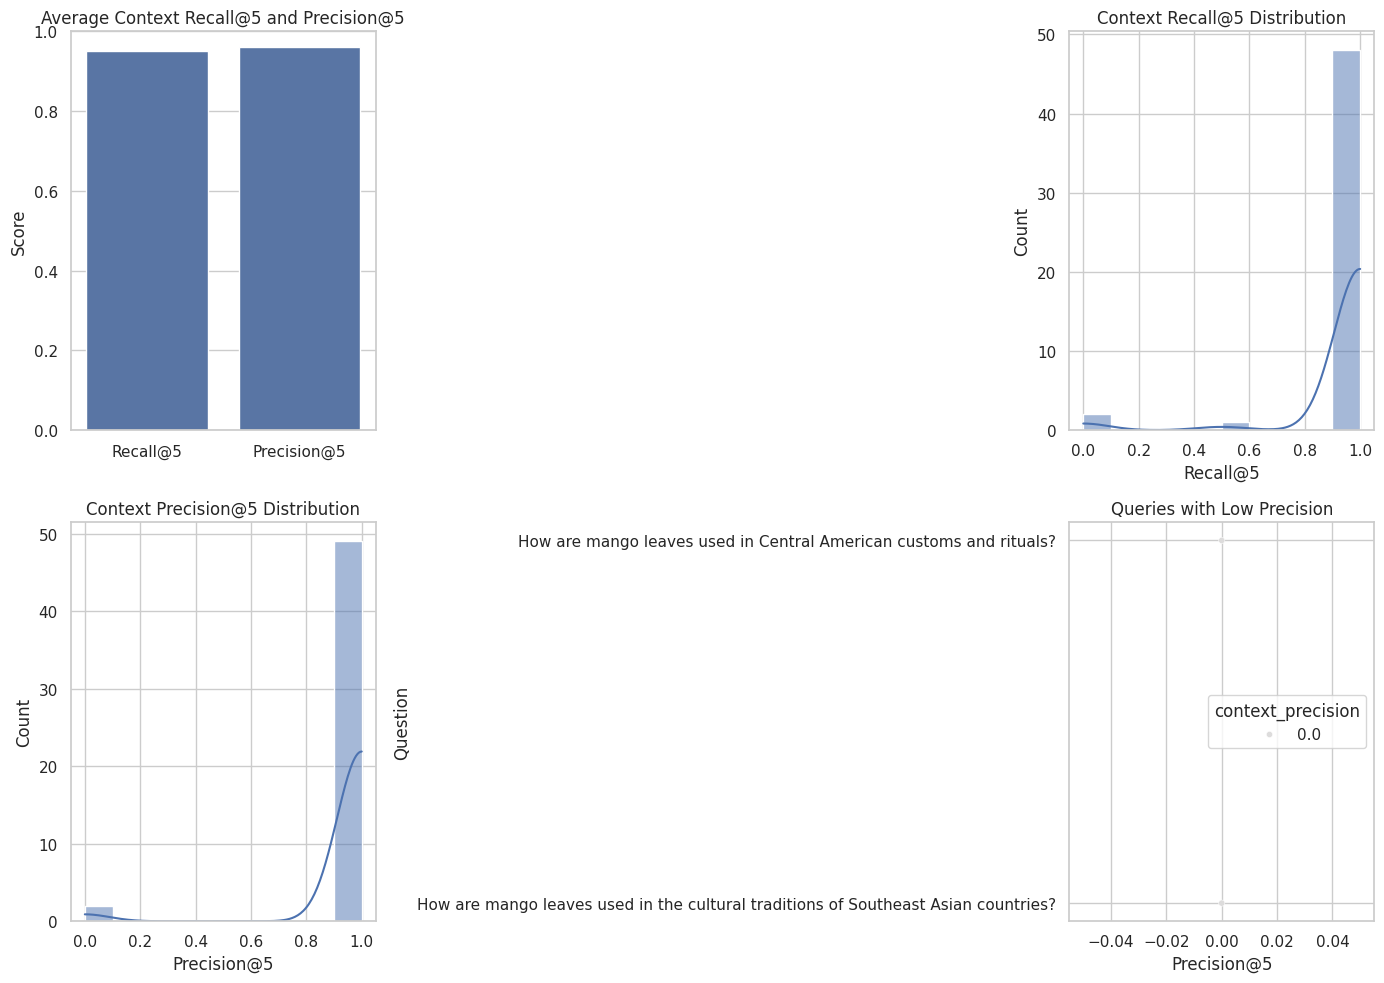

In [ ]:
#@title Visualizing Our RAGAS Results
def summarize_ragas_results(recall_df, precision_df):
    """
    Summarize and analyze the RAGAS metrics results.
    Args:
        recall_df (DataFrame): DataFrame containing recall scores.
        precision_df (DataFrame): DataFrame containing precision scores.
    """
    # Calculate average scores
    avg_recall = recall_df['context_recall'].mean()
    avg_precision = precision_df['context_precision'].mean()

    # Display the summary
    print(f"Average Context Recall@5: {avg_recall:.2f}")
    print(f"Average Context Precision@5: {avg_precision:.2f}")

    # Identify queries with low precision
    low_precision_queries = precision_df[precision_df['context_precision'] < 0.5]

    # Visualization
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    # Bar plot for average recall and precision
    sns.barplot(x=['Recall@5', 'Precision@5'], y=[avg_recall, avg_precision], ax=axes[0, 0])
    axes[0, 0].set_ylim(0, 1)
    axes[0, 0].set_title('Average Context Recall@5 and Precision@5')
    axes[0, 0].set_ylabel('Score')

    # Distribution plot for recall
    sns.histplot(recall_df['context_recall'], bins=10, kde=True, ax=axes[0, 1])
    axes[0, 1].set_title('Context Recall@5 Distribution')
    axes[0, 1].set_xlabel('Recall@5')
    axes[0, 1].set_ylabel('Count')

    # Distribution plot for precision
    sns.histplot(precision_df['context_precision'], bins=10, kde=True, ax=axes[1, 0])
    axes[1, 0].set_title('Context Precision@5 Distribution')
    axes[1, 0].set_xlabel('Precision@5')
    axes[1, 0].set_ylabel('Count')

    # Scatter plot for low precision queries
    if not low_precision_queries.empty:
        sns.scatterplot(data=low_precision_queries, x='context_precision', y='question', hue='context_precision', palette='coolwarm', size='context_precision', sizes=(20, 200), ax=axes[1, 1])
        axes[1, 1].set_title('Queries with Low Precision')
        axes[1, 1].set_xlabel('Precision@5')
        axes[1, 1].set_ylabel('Question')
    else:
        axes[1, 1].text(0.5, 0.5, 'No low precision queries found', horizontalalignment='center', verticalalignment='center', fontsize=12)
        axes[1, 1].set_title('Queries with Low Precision')
        axes[1, 1].set_xlabel('Precision@5')
        axes[1, 1].set_ylabel('Question')

    plt.tight_layout()
    plt.show()

# Call the function to summarize RAGAS results with enhanced visualizations
summarize_ragas_results(recall_df, precision_df)

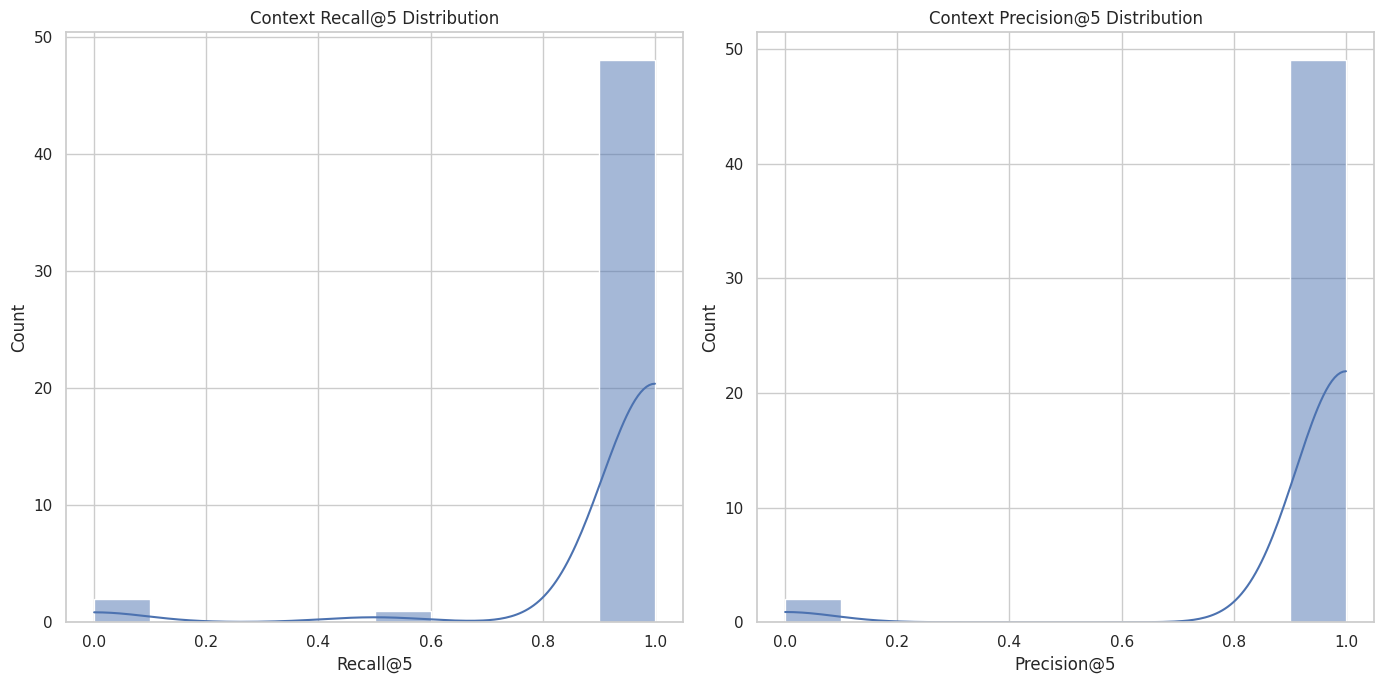

In [ ]:
#@title Detailed Visualizations of our Context Recall and Precision
import matplotlib.pyplot as plt
import seaborn as sns

def plot_ragas_metrics(recall_df, precision_df):
    """
    Plot RAGAS metrics using seaborn and matplotlib.
    Args:
        recall_df (DataFrame): DataFrame containing recall scores.
        precision_df (DataFrame): DataFrame containing precision scores.
    """
    plt.figure(figsize=(14, 7))

    # Plot context recall
    plt.subplot(1, 2, 1)
    sns.histplot(recall_df['context_recall'], bins=10, kde=True)
    plt.title('Context Recall@5 Distribution')
    plt.xlabel('Recall@5')

    # Plot context precision
    plt.subplot(1, 2, 2)
    sns.histplot(precision_df['context_precision'], bins=10, kde=True)
    plt.title('Context Precision@5 Distribution')
    plt.xlabel('Precision@5')

    plt.tight_layout()
    plt.show()

# Call the function to plot RAGAS metrics
plot_ragas_metrics(recall_df, precision_df)


# Calculating Faithfulness, Answer Relevance, and Bias

In [11]:
#@title From our RAG pipeline

dataset = Dataset.from_dict(data_samples)
faithfulness_score = evaluate(dataset, metrics=[faithfulness])
faithfulness_score_df = faithfulness_score.to_pandas()

#faithfulness_score_df
# calc the % of faithfulness vs individual distribution

average_faithfulness = faithfulness_score_df['faithfulness'].mean()
print(f"Average Faithfulness: {average_faithfulness * 100:.2f}%")

Evaluating:   0%|          | 0/51 [00:00<?, ?it/s]

Average Faithfulness: 99.02%


Evaluating:   0%|          | 0/51 [00:00<?, ?it/s]

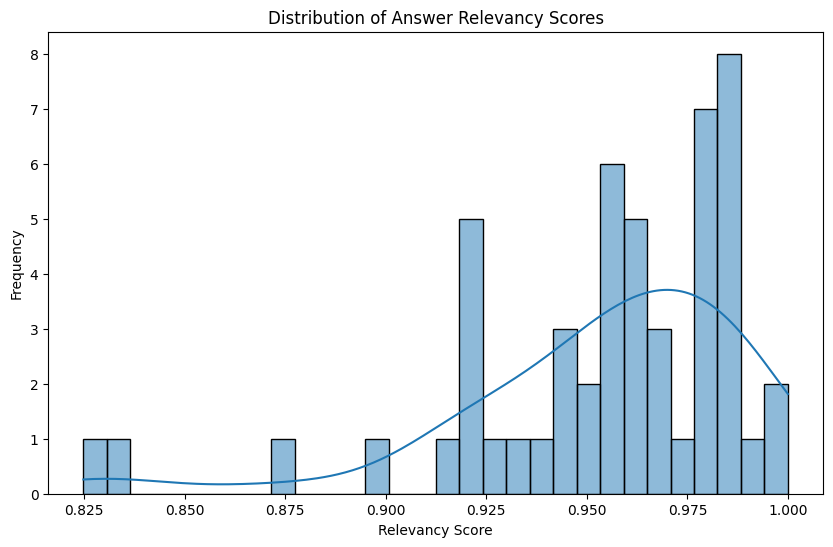

Average Answer Relevance: 95.36%


In [12]:
#@title Calculate answer relevancy

answer_relevance_score = evaluate(dataset, metrics=[answer_relevancy])
answer_relevance_df = answer_relevance_score.to_pandas()

# Visualize relev scores (using seaborn/matplt)

def visualize_answer_relevancy(relevancy_df):
    plt.figure(figsize=(10, 6))
    sns.histplot(relevancy_df['answer_relevancy'], kde=True, bins=30)
    plt.title('Distribution of Answer Relevancy Scores')
    plt.xlabel('Relevancy Score')
    plt.ylabel('Frequency')
    plt.show()

visualize_answer_relevancy(answer_relevance_df)

# Calculate percentage of Answer Relevance
average_answer_relevance = answer_relevance_df['answer_relevancy'].mean()
print(f"Average Answer Relevance: {average_answer_relevance * 100:.2f}%")

In [14]:
#@title Geographical Bias Evaluation

# Define a function to create test cases for geographical bias
def create_test_cases(data):
    test_cases = []
    for i, row in data.iterrows():
        input_text = row['user_query']
        actual_output = row['chatbot_response']
        test_cases.append(LLMTestCase(input=input_text, actual_output=actual_output))
    return test_cases

# Create test cases from the dataset
test_cases = create_test_cases(data)

# Initialize the BiasMetric with a threshold
metric = BiasMetric(threshold=0.5, async_mode=False)

# Evaluate each test case and store the results
bias_scores = []
reasons = []
for test_case in test_cases:
    metric.measure(test_case)
    bias_scores.append(metric.score)
    reasons.append(metric.reason)

# Store results in a DataFrame
geographical_bias_df = pd.DataFrame({
    'Input': [tc.input for tc in test_cases],
    'Output': [tc.actual_output for tc in test_cases],
    'Bias Score': bias_scores,
    'Reason': reasons
})

# Calculate average geographical bias
average_geographical_bias = geographical_bias_df['Bias Score'].mean()
print(f"Average Geographical Bias: {average_geographical_bias * 100:.2f}%")

# Display the DataFrame
geographical_bias_df

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Average Geographical Bias: 1.96%


,Input,Output,Bias Score,Reason
0,Where do mangoes originally come from?,Mangoes are native to South Asia and have been...,0.0,The score is 0.00 because the actual output is...
1,Can you recommend a sweet but less common type...,The Kesar mango is known for its unique sweetn...,0.0,The score is 0.00 because the actual output is...
2,Are there any savory recipes using mangoes?,"Yes, mango salsa is a popular savory dish that...",0.0,The score is 0.00 because the actual output is...
3,What is the peak season for mangoes?,The peak season for mangoes is typically from ...,0.0,The score is 0.00 because the actual output is...
4,Do mangoes have any cultural significance?,Mangoes hold cultural significance in various ...,0.0,The score is 0.00 because the actual output is...
5,What are some unique ways to enjoy mangoes?,One unique way to enjoy mangoes is by making m...,0.0,The score is 0.00 because the actual output is...
6,Can mangoes be used in beauty products?,"Yes, mango butter is commonly used in skincare...",0.0,The score is 0.00 because the actual output sh...
7,Are there any superstitions or beliefs associa...,"In some cultures, mangoes are considered a sym...",0.0,The score is 0.00 because the output is comple...
8,How do different mango varieties differ in tas...,Different mango varieties vary in taste and te...,0.0,The score is 0.00 because the actual output is...
9,What are the environmental impacts of mango cu...,Mango cultivation can have environmental impac...,0.0,The score is 0.00 because the actual output is...


In [16]:
#@title Overall Bias

def evaluate_geographical_bias(data):
    metric = BiasMetric(threshold=0.5, async_mode=False)
    test_cases = [LLMTestCase(input=row['user_query'], actual_output=row['chatbot_response']) for _, row in data.iterrows()]
    bias_scores = []

    for test_case in test_cases:
        metric.measure(test_case)
        bias_scores.append(metric.score)

    avg_bias = sum(bias_scores) / len(bias_scores)
    print(f"Overall Geographical Bias Score: {avg_bias:.2f}")

evaluate_geographical_bias(data)

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Overall Geographical Bias Score: 0.02


In [ ]:
#@title Biased output [callout]

# TODO: Import deepeval class to test ASYNC io stuff

input_text = "Tell me about mangoes from Mexico."
actual_output = "Mexican mangoes are often less desirable due to their sour taste."

metric = BiasMetric(threshold=0.5, async_mode=False)
test_case = LLMTestCase(input=input_text, actual_output=actual_output)

metric.measure(test_case)
print(f"Bias Score: {metric.score}")
print(f"Reason: {metric.reason}")


Output()

Bias Score: 1.0
Reason: The score is 1.00 because the statement 'Mexican mangoes are often less desirable due to their sour taste' reveals an ethnic bias by making a generalization about products based on their origin. A more neutral phrasing like 'Some people may find certain varieties of mangoes to be less sweet, but preferences for taste can vary widely' would have been more appropriate.
